# Crafting _Evasion Attacks_ against Machine Learning Models

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

**Adversarial machine learning (`AML`) is a subfield of machine learning that focuses on developing algorithms and techniques that can withstand and respond to adversarial attacks.** 

**Adversarial attacks are a type of cyber attack where an attacker deliberately manipulates data inputs to ML models with the aim of causing them to produce incorrect outputs.** 

**`AML` aims to improve the robustness and security of ML models by identifying vulnerabilities and developing countermeasures to mitigate the impact of adversarial attacks. A range of techniques have been developed for `AML`, including `adversarial training` (_training models on adversarial examples_), and `defensive distillation` (_creating a distilled version of a model that is resistant to adversarial attacks_).**

**`AML` is an active area of research, as ML models continue to be deployed in a wide range of applications where they may be vulnerable to attack.**

**One of the alternatives for making models more resilient against adversarial attacks is `adversarial training`. In `adversarial training`, we generate adversarial examples and use them as samples (with their correct labels) for training (retraining) the original model, making it more robust.**

**In this notebook we will be exploring a type of attack called _evasion_ (we have already explored this a bit in our notebooks on [Evasion Attacks with Keras & Tensorflow](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/bbe9c0a77499fa68de7c6d53bf5ef7e0b43a25e0/ML%20Adversarial/evasion_attacks_FGSM.ipynb)). But _what is evasion?_ Evasion attacks happen when the network is fed an “_adversarial example_”, i.e., a carefully perturbed input that looks and feels the same as its untampered copy to a human — but that completely throws off the ML model.**

![image](<https://cdn.vox-cdn.com/thumbor/uXLBjJlvk7QNC_HfXbkThG3sHPs=/0x0:652x316/1200x800/filters:focal(274x106:378x210):no_upscale()/cdn.vox-cdn.com/uploads/chorus_image/image/58191589/adversarial_patch_.0.gif>)

**The attacks performed in this notebook (unlike the attacks on [other notebooks](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/bbe9c0a77499fa68de7c6d53bf5ef7e0b43a25e0/ML%20Adversarial/evasion_attacks_FGSM.ipynb) where we crafted them _"by hand"_) are done using the [SecML: A library for Secure and Explainable Machine Learning](https://gitlab.com/secml/secml).**

**The SecML library has machine learning utilities very similar to other ML modules (Scikit Learn, Pytorch), which makes very easy to create models using SecML (especially if you are already used to those other ML libraries).**

In [1]:
seed = 42

from secml.data.loader import CDLRandomBlobs

dataset = CDLRandomBlobs(n_features=2, 
                         centers=[[-2, 0], [2, -2], [2, 2]], 
                         cluster_std=0.8,
                         n_samples=1100,
                         random_state=seed).load()

from secml.data.splitter import CTrainTestSplit

splitter = CTrainTestSplit(
    train_size=int(dataset.X.shape[0] * 0.9), test_size=int(dataset.X.shape[0] * 0.1), random_state=seed)
tr, ts = splitter.split(dataset)

from secml.ml.features import CNormalizerMinMax

normilizer = CNormalizerMinMax()
tr.X = normilizer.fit_transform(tr.X)
ts.X = normilizer.transform(ts.X)

from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.kernels import CKernelRBF

model = CClassifierMulticlassOVA(CClassifierSVM, kernel=CKernelRBF())

from secml.data.splitter import CDataSplitterKFold

validation_splitter = CDataSplitterKFold(num_folds=3, random_state=seed)

from secml.ml.peval.metrics import CMetricAccuracy

metric = CMetricAccuracy()

hyper_params = {'C': [0.01, 0.1, 1], 'kernel.gamma': [10, 100, 1000]}

print("Hypertunning...")
best_params = model.estimate_parameters(
    dataset=tr, 
    parameters=hyper_params, 
    splitter=validation_splitter, 
    metric='accuracy', 
    perf_evaluator='xval'
)

print(f'''
Hypertunning Complete.
Results: C = {best_params['C']}, kernel.gamma = {best_params['kernel.gamma']}.''')

model.fit(tr.X, tr.Y)

y_pred = model.predict(ts.X)
score = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
print(f"\nAccuracy: {round(score, 2) * 100}%.")

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(list(ts.Y), list(y_pred))

import plotly.express as px
fig = px.imshow(matrix,
                labels=dict(x="Predicted", y="True label"),
                x=['Class 1', 'Class 2', 'Class 3'],
                y=['Class 1', 'Class 2', 'Class 3'],
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix (SVM)',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Hypertunning...

Hypertunning Complete.
Results: C = 0.01, kernel.gamma = 10.

Accuracy: 100.0%.


**Practically a perfect classifier. Let us change this!**

**We are going to create an adversarial example against the SVM classifier using the gradient-based maximum-confidence algorithm proposed in:**

- **Biggio, et al. [Evasion Attacks against Machine Learning at Test Time](https://arxiv.org/abs/1708.06131).**
- **Melis et al. [Is deep learning safe for robot vision? adversarial examples against the icub humanoid](https://arxiv.org/abs/1708.06939).**
- **Demontis et al. [Why Do Adversarial Attacks Transfer? Explaining Transferability of Evasion and Poisoning Attacks](https://www.usenix.org/conference/usenixsecurity19/presentation/demontis).**

**In SecML, we use this attack by calling the `CAttackEvasionPGDLS` class.** 

**First, we define some attack parameters:**

- **`noise_type` refers to the type of perturbation (`l1` or `l2`).**
- **`dmax` (also called "epsilon") refers to the perturbation size (a Real number, like 0.2).**
- **`lb, ub` refers to the bounds of the attack space. Since all samples are normalized between 0 and 1, this space (in this example) is  0,  1  (`None` for unbounded).**
- **`y_target`refers to the target of the attack (`None` for error-generic attacks, or a class label for error-specific attacks).**

In [12]:
x0, y0 = ts[5, :].X, ts[5, :].Y  

from secml.adv.attacks.evasion import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(
    classifier=model,
    double_init_ds=tr, #training set
    double_init=False,
    distance='l2', 
    dmax=0.4, 
    lb=0, ub=1,
    solver_params= {'eta': 0.3, 'eta_min': 0.1,'eta_max': None,'max_iter': 100, 'eps': 1e-4},
    y_target=None)

# Run the evasion attack on sample

y_pred_pgdls,_,adv_ds_pgdls,_ = pgd_ls_attack.run(x0, y0)
print(f"Original sample label: {y0.item()}." )
print(f"Adversarial example label: {y_pred_pgdls.item()}")
print(f"Nº of times the attack algorithm queries the classifier gradient function: {pgd_ls_attack.grad_eval}")

Original sample label: 0.
Adversarial example label: 1
Nº of times the attack algorithm queries the classifier gradient function: 8


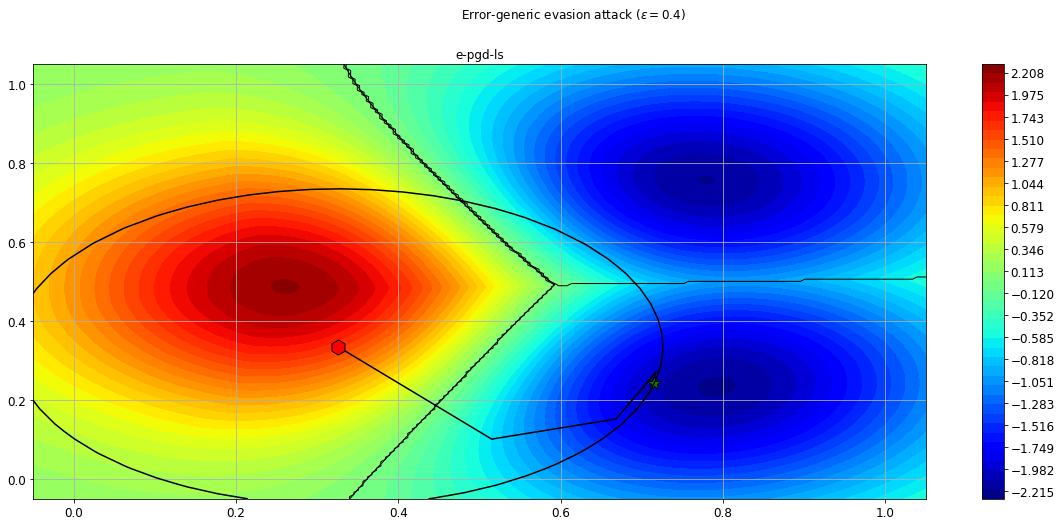

In [23]:
from secml.figure import CFigure
%matplotlib inline

fig = CFigure(width=20, height=8, markersize=15)
    
from secml.optim.constraints import CConstraintL2
constraint = CConstraintL2(center=x0, radius=0.4)

for i, (attack, adv_ds) in enumerate([(pgd_ls_attack, adv_ds_pgdls)]):

    fig.subplot(i + 1)
    
    # Convenience function for plotting the attack objective function
    fig.sp.plot_fun(attack.objective_function, plot_levels=True, 
                    multipoint=True, n_grid_points=200)
                    
    # Let's also plot the decision boundaries of the classifier
    fig.sp.plot_decision_regions(model, plot_background=False, n_grid_points=200)
    
    # Construct an array with the original point and the adversarial example
    adv_path = x0.append(adv_ds.X, axis=0)
    
    fig.sp.plot_path(attack.x_seq)
    
    fig.sp.plot_constraint(constraint)
    
    fig.sp.title(attack.class_type)
    fig.sp.grid(grid_on=True)

fig.title(r"Error-generic evasion attack ($\varepsilon={:}$)".format(0.4))

fig.show()

**The initial sample _(red hexagon)_ has been perturbed in feature space so that is actually classified as a point from another class. The final _adversarial example_ is the green star. The circle represents the  _l2_ constraint as a black circle (with the specified maximum perturbation `dmax`).**

**To evaluate the robustness of a classifier, we can increase the value for the maximum perturbation.**

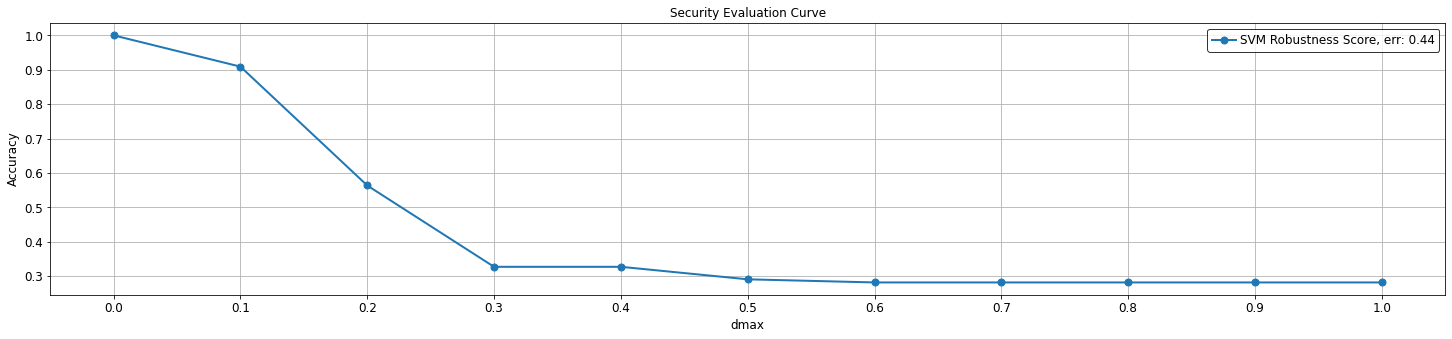

In [27]:
# Perturbation boundaries
from secml.array import CArray
e_vals = CArray.arange(start=0, step=0.1, stop=1.1) 

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run evaluation on the test set
print("Running security evaluation...") 
sec_eval.run_sec_eval(ts)

from secml.figure import CFigure
fig = CFigure(height=5, width=25)
fig.sp.plot_sec_eval(sec_eval.sec_eval_data, marker='o', label='SVM Robustness Score', show_average=True)

**Most of the research in Ml evasion focuses on attacks created with small perturbations (the kind that are difficult for humans to perceive as attacks). And as we can see, our SVM is quite vulnerable to adversarial attacks (even with small perturbations of $\epsilon = 0.3$). Large perturbations can full any classifier, but they fail to evade human detection.**

----

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).